In [1]:
# splicing categories are pairwise (do they need a reference?)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from venn import venn

from collections import defaultdict

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import Align

from data_loading import (load_annotated_6k_collection, 
                          load_annotated_gencode_tfs,
                          load_valid_isoform_clones)

In [2]:
tfs = load_annotated_6k_collection()
tfs_gc = load_annotated_gencode_tfs()
clones = load_valid_isoform_clones()
novel = set(clones.loc[clones['is_novel_isoform'], 'clone_acc'].values)

path_gencode_aa_seq = '../data/external/gencode.v30.pc_translations.fa'
ensembl_proteins = defaultdict(list)
ensembl_aa_seq = {}
for record in SeqIO.parse(path_gencode_aa_seq, 'fasta'):
    ids = record.id.split('|')
    ensembl_proteins[str(record.seq)].append((ids[0].split('.')[0], ids[1].split('.')[0], ids[5]))
    ensembl_aa_seq[ids[5]] = str(record.seq)

for tf in tfs.values():
    for isoform in tf.orfs:
        if isoform.aa_seq in ensembl_proteins:
            isoform.ensembl_protein_ids = [ids[0] for ids in ensembl_proteins[isoform.aa_seq]]
            isoform.ensembl_transcript_ids = [ids[1] for ids in ensembl_proteins[isoform.aa_seq]]
            isoform.ensembl_transcript_names = [ids[2] for ids in ensembl_proteins[isoform.aa_seq]]

tfs['ATF2']['ATF2-1'].ensembl_protein_ids

reading from cache
reading from cache


['ENSP00000264110', 'ENSP00000376327']

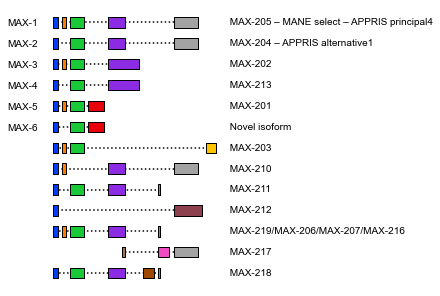

In [3]:
tfs['MAX'].exon_diagram()

In [4]:
tfs['ATF2']['ATF2-2'].is_MANE_select_transcript

False

In [5]:
print(len([iso for tf in tfs.values() for iso in tf.cloned_isoforms]), 'total cloned isoforms')
print(len([iso for tf in tfs.values() for iso in tf.cloned_isoforms
           if iso.ensembl_protein_ids is not None]), 'isoforms matched to ensembl')
print(len([iso for tf in tfs.values() for iso in tf.cloned_isoforms
           if not iso.is_novel_isoform()]), 'according to previous mapping')

756 total cloned isoforms
569 isoforms matched to ensembl
569 according to previous mapping


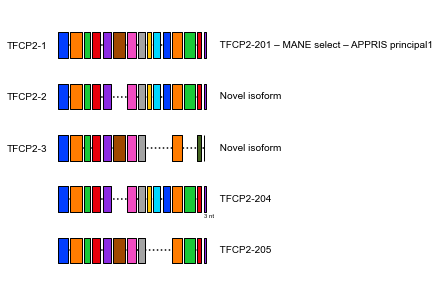

In [6]:
tfs['TFCP2'].exon_diagram()

In [7]:
tfs['TFCP2'].orfs

[Clone acc: TFCP2|1/3|03E08
 Isoform: TFCP2-201 / ENSP00000257915 / ENST00000257915
 length: 502 aa,
 Clone acc: TFCP2|2/3|03H07
 Isoform: TFCP2-2
 length: 451 aa,
 Clone acc: TFCP2|3/3|03F10
 Isoform: TFCP2-3
 length: 368 aa,
 Isoform: TFCP2-204 / ENSP00000447991 / ENST00000548115
 length: 450 aa,
 Isoform: TFCP2-205 / ENSP00000449742 / ENST00000549867
 length: 424 aa]

In [8]:
# something going wrong with RORA

tfs['RORA']['RORA-1']

Clone acc: RORA|1/2|05G07
Isoform: RORA-204 / ENSP00000402971 / ENST00000449337
length: 468 aa

In [9]:
# number of clones with exact match
# number of clones with 1, 2, 3, 4, 5 different AA
# number of clones with different insertions / deletions

In [10]:
tfs['ZNF747'].orfs

[Clone acc: ZNF747|1/4|03E01
 Isoform: AC002310.5-201|ZNF747-203 / ENSP00000454241|ENSP00000457274 / ENST00000569360|ENST00000568028
 length: 330 aa,
 Clone acc: ZNF747|2/4|03B01
 Isoform: ZNF747-201 / ENSP00000252799 / ENST00000252799
 length: 191 aa,
 Clone acc: ZNF747|3/4|02E12
 Isoform: ZNF747-202 / ENSP00000378528 / ENST00000395094
 length: 190 aa]

In [11]:
seq_a = tfs['ZNF747']['ZNF747-2'].aa_seq
seq_b = ensembl_aa_seq['ZNF747-202']
aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 1
aligner.mismatch_score = -1
aligner.gap_score = -1
alignment = aligner.align(seq_a, seq_b)[0].__str__()
print(alignment)

MTDPSLGLTVPMAPPLAPLPPRDPNGAGSEWRKPGAVSFADVAVYFSREEWGCLRPAQRALYRDVMRETYGHLGALGESPTCLPGPCASTGPAAPLGAACGVGGPGAGQAASSQRGVCVLLPQESEAASRRSSPGWRRRPNCGIRLPRIRRWRSVRQKRTQQIPETRKRKDKGKGREPWRSPTLWPPGLLG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||-|||||||||||||||||||||||||||||
MTDPSLGLTVPMAPPLAPLPPRDPNGAGSEWRKPGAVSFADVAVYFSREEWGCLRPAQRALYRDVMRETYGHLGALGESPTCLPGPCASTGPAAPLGAACGVGGPGAGQAASSQRGVCVLLPQESEAASRRSSPGWRRRPNCGIRLPRIRRWRSVRQKRTQ-IPETRKRKDKGKGREPWRSPTLWPPGLLG



In [12]:
print(len([iso for tf in tfs.values() for iso in tf.orfs if iso.ensembl_protein_ids is not None]),
      len([iso for tf in tfs.values() for iso in tf.orfs if iso.ensembl_protein_ids is None]))
print(clones['is_novel_isoform'].value_counts())

1189 187
False    567
True     191
Name: is_novel_isoform, dtype: int64


In [13]:
novel = set(clones.loc[clones['is_novel_isoform'], 'clone_acc'].values)
print('isoforms im saying are novel and previously were matched')
[iso for tf in tfs.values() for iso in tf.orfs if iso.ensembl_protein_ids is None and iso.clone_acc not in novel]

isoforms im saying are novel and previously were matched


[]

In [16]:
[iso for tf in tfs.values() for iso in tf.cloned_isoforms if iso.ensembl_protein_ids is not None and iso.clone_acc in novel]

[Clone acc: ZNF280D|1/2|04D07
 Isoform: AC090517.4-201 / ENSP00000453045 / ENST00000559000
 length: 747 aa,
 Clone acc: ZBTB32|2/3|12C09
 Isoform: ZBTB32-206 / ENSP00000433657 / ENST00000481182
 length: 302 aa]

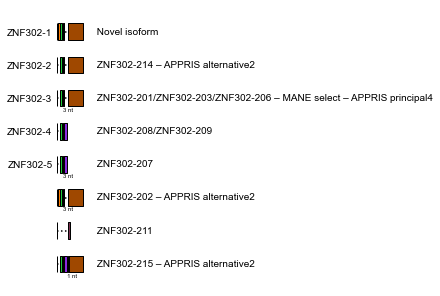

In [17]:
tfs['ZNF302'].exon_diagram()

In [18]:
# check alignment of NT sequence...
print(aligner.align(tfs['ZNF302']['ZNF302-1'].aa_seq, ensembl_aa_seq['ZNF302-202'])[0].__str__())

MSQRQYPECYLAPNGCLVSNCGVNKMSNEELVGQNHGMEGEACTGGDVTFSDVAIDFSHEEWACLDSAQRDLYKDVMVQNYENLVSVAGLSVTKPYVIMLLEDGKEPWMMEKKLSKDWESRWENKELSTKKDICDEDSPQPVTMEKVVKQSYEFSNSNKNLEYTECDTFRSTFHSKSTLSEPQNNSAEGNSHKYDILKKNLSKKSVIKSERINGGKKLLNSNKSGAAFNQSKSLTLPQTCNREKIYTCSECGKAFGKQSILSRHWRIHTGEKPYECRECGKTFSHGSSLTRHQISHSGEKPYKCIECGKAFSHGSSLTNHQSTHTGEKPYECMNCGKSFSRVSLLIQHLRIHTQEKRYECRICGKAFIHSSSLIHHQKSHTGEKPYECRECGKAFCCSSHLTQHQRIHSMKKKYECNKCLKVFSSFSFLVQHQSIHTEEKPFEV
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||-|||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
MSQRQYPECYLAPNGCLVSNCGVNKMSNEELVGQNHGMEGEACTGGDVTFSDVAIDFSHEEWACLDSAQRDLYKDVMVQNYENLVSV-GLSVTKPYVIMLLEDGKEPWMM

In [19]:
tfs['ZNF302']

Gene: ZNF302
Isoforms: ['ZNF302-1', 'ZNF302-2', 'ZNF302-3', 'ZNF302-4', 'ZNF302-5', 'ZNF302-202', 'ZNF302-211', 'ZNF302-215']

In [20]:
tfs['ZNF302'].orfs

[Clone acc: ZNF302|1/5|06F09
 Isoform: ZNF302-1
 length: 444 aa,
 Clone acc: ZNF302|2/5|06B07
 Isoform: ZNF302-214 / ENSP00000481754 / ENST00000613363
 length: 400 aa,
 Clone acc: ZNF302|3/5|06H06
 Isoform: ZNF302-201|ZNF302-203|ZNF302-206 / ENSP00000405219|ENSP00000391067|ENSP00000421028 / ENST00000423823|ENST00000457781|ENST00000505242
 length: 399 aa,
 Clone acc: ZNF302|4/5|06G08
 Isoform: ZNF302-208|ZNF302-209 / ENSP00000424292|ENSP00000421201 / ENST00000506901|ENST00000507959
 length: 132 aa,
 Clone acc: ZNF302|5/5|06H08
 Isoform: ZNF302-207 / ENSP00000423235 / ENST00000505365
 length: 131 aa,
 Isoform: ZNF302-202 / ENSP00000396379 / ENST00000446502
 length: 443 aa,
 Isoform: ZNF302-211 / ENSP00000477197 / ENST00000509528
 length: 28 aa,
 Isoform: ZNF302-215 / ENSP00000486577 / ENST00000627982
 length: 478 aa]

In [21]:
# TEST
from data_loading import load_valid_isoform_clones
clones = load_valid_isoform_clones()
clones['is_novel_isoform'].value_counts()  # CHECK novel isoform against current results

False    567
True     191
Name: is_novel_isoform, dtype: int64

In [22]:
clones.loc[clones['clone_acc'] == 'ATF2|1/6|12H04', 'aa_seq'].values

array(['MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHKHKHEMTLKFGPARNDSVIVADQTPTPTRFLKNCEEVGLFNELASPFENEFKKASEDDIKKMPLDLSPLATPIIRSKIEEPSVVETTHQDSPLPHPESTTSDEKEVPLAQTAQPTSAIVRPASLQVPNVLLTSSDSSVIIQQAVPSPTSSTVITQAPSSNRPIVPVPGPFPLLLHLPNGQTMPVAIPASITSSNVHVPAAVPLVRPVTMVPSVPGIPGPSSPQPVQSEAKMRLKAALTQQHPPVTNGDTVKGHGSGLVRTQSEESRPQSLQQPATSTTETPASPAHTTPQTQSTSGRRRRAANEDPDEKRRKFLERNRAAASRCRQKRKVWVQSLEKKAEDLSSLNGQLQSEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSEDISVPSSPHTEAIQHSSVSTSNGVSSTSKAEAVATSVLTQMADQSTEPALSQIVMAPSSQSQPSGS'],
      dtype=object)

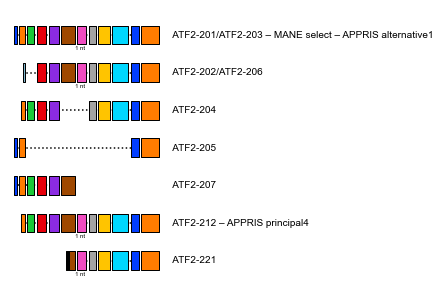

In [23]:
tfs_gc['ATF2'].exon_diagram()

In [24]:
print((tfs_gc['ATF2'].exons[0].start, tfs_gc['ATF2'].exons[0].end))
print((tfs_gc['ATF2'].exons[-1].start, tfs_gc['ATF2'].exons[-1].end))

(175136411, 175136443)
(175074611, 175074835)


349
348
2492035 2492079


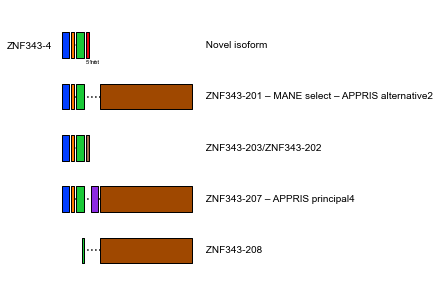

In [25]:
print(len(tfs['ZNF343']['ZNF343-4'].clone_nt_seq))
print(len(tfs['ZNF343']['ZNF343-4'].nt_seq))
print(tfs['ZNF343']['ZNF343-4'].exons[-1].start, tfs['ZNF343']['ZNF343-4'].exons[-1].end)
tfs['ZNF343'].exon_diagram()

In [27]:
# when is the sum of exon length equal to the aa sequence?

exon_eq_coding = [orf for tf in tfs.values() for orf in tf.cloned_isoforms if sum(len(e) for e in orf.exons) == len(orf.nt_seq)]
exon_eq_clone = [orf for tf in tfs.values() for orf in tf.cloned_isoforms 
                  if (sum(len(e) for e in orf.exons) == len(orf.clone_nt_seq)) and (len(orf.clone_nt_seq) != len(orf.nt_seq))]
print(len(exon_eq_coding), len(exon_eq_clone))


756 0


In [28]:
# investigate the ones where the exon includes stop etc etc.

In [30]:
tfs['GMEB1']['GMEB1-1'].ensembl_transcript_ids

['ENST00000373816', 'ENST00000361872']

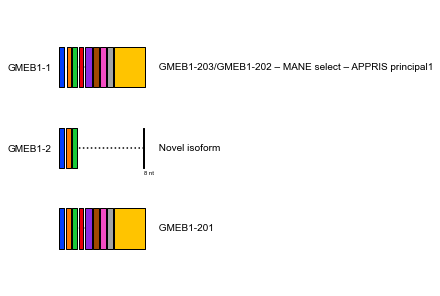

In [31]:
# 28714073        28714770n
# 28714739        28714770
tfs['GMEB1'].exon_diagram()

1771 1458
[Exon of SMAD4|1/2|01A02 249 nt
, Exon of SMAD4|1/2|01A02 175 nt
, Exon of SMAD4|1/2|01A02 30 nt
, Exon of SMAD4|1/2|01A02 213 nt
, Exon of SMAD4|1/2|01A02 120 nt
, Exon of SMAD4|1/2|01A02 117 nt
, Exon of SMAD4|1/2|01A02 51 nt
, Exon of SMAD4|1/2|01A02 184 nt
, Exon of SMAD4|1/2|01A02 169 nt
, Exon of SMAD4|1/2|01A02 139 nt
, Exon of SMAD4|1/2|01A02 11 nt
]


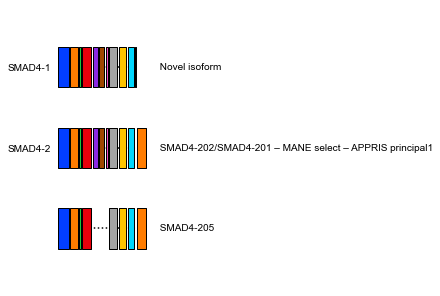

In [32]:
#sorted([orf for tf in tfs.values() for orf in tf.orfs],
#        key=lambda x: sum(len(e) for e in x.exons) - len(x.nt_seq))[-1]


print(len(tfs['SMAD4']['SMAD4-1'].clone_nt_seq),
      len(tfs['SMAD4']['SMAD4-1'].nt_seq))
print(tfs['SMAD4']['SMAD4-1'].exons)
tfs['SMAD4'].exon_diagram()

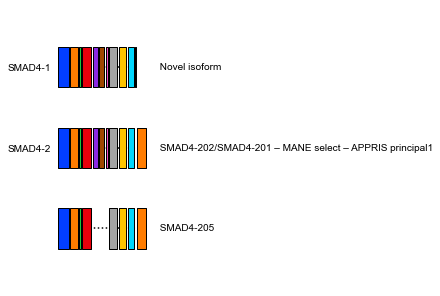

In [33]:
tfs['SMAD4'].exon_diagram()

In [34]:
orf = tfs['SMAD4']['SMAD4-1']
print(
orf.start,
orf.exons[0].start,
orf.end,
orf.exons[-1].end
)

51047046 51047046 51077317 51077317


In [35]:
tfs['SMAD4']['SMAD4-1'].strand

'+'

In [36]:
# GMEB1-2
tfs['GMEB1']['GMEB1-2'].exons

[Exon of GMEB1|2/2|02A08 128 nt,
 Exon of GMEB1|2/2|02A08 113 nt,
 Exon of GMEB1|2/2|02A08 125 nt,
 Exon of GMEB1|2/2|02A08 24 nt]

In [37]:
len(tfs['GMEB1']['GMEB1-2'].clone_nt_seq)

398

In [38]:
sum([len(orf.clone_nt_seq) % 3 != 0 for orf in exon_eq_clone])

0

In [41]:
sum([len(orf.clone_nt_seq) % 3 != 0 for tf in tfs.values() for orf in tf.cloned_isoforms])

76

In [42]:
len([orf for tf in tfs.values() for orf in tf.orfs])

1376

In [44]:
def perfect_seq(s):
    stop_codons = {'TAG', 'TAA', 'TGA'}
    codons = [s[i:i + 3] for i in range(0, len(s), 3)]
    return len(s) % 3 == 0 and not any(codon in stop_codons for codon in codons)


suspect_seqs = {orf.name: orf.clone_nt_seq for tf in tfs.values() for orf in tf.cloned_isoforms if not perfect_seq(orf.clone_nt_seq)}
print(len(suspect_seqs), 'clone sequences where the length is not a multiple of 3 or there is a stop codon')
[(name, s[-(len(s) % 3):]) for name, s in suspect_seqs.items()]

197 clone sequences where the length is not a multiple of 3 or there is a stop codon


[('PRRX1-1',
  'ATGACCTCCAGCTACGGGCACGTTCTGGAGCGGCAACCGGCGCTGGGCGGCCGCTTGGACAGCCCGGGCAACCTCGACACCCTGCAGGCGAAAAAGAACTTCTCCGTCAGTCACCTGCTAGACCTGGAGGAAGCCGGGGACATGGTGGCGGCACAGGCGGATGAGAACGTGGGCGAGGCTGGCCGGAGCCTGCTGGAGTCGCCGGGACTCACCAGCGGCAGCGACACCCCGCAGCAGGACAATGACCAGCTGAACTCAGAAGAAAAAAAGAAGAGAAAGCAGCGAAGGAATAGGACAACCTTCAATAGCAGCCAGCTGCAGGCTTTGGAGCGTGTCTTTGAGCGGACACACTATCCTGATGCTTTTGTGCGAGAAGACCTTGCCCGCCGGGTGAACCTCACCGAGGCGAGAGTGCAGGTGTGGTTTCAGAACCGAAGAGCCAAGTTCCGCAGGAATGAGAGAGCCATGCTAGCCAATAAAAACGCTTCCCTCCTCAAATCCTACTCAGGAGACGTGACTGCTGTGGAGCAGCCCATCGTACCTCGTCCTGCTCCGAGACCCACCGATTATCTCTCCTGGGGGACAGCGTCTCCGTACAGATCCTCGTCCCTCCCAAGATGTTGTTTACACGAGGGGCTTCATAACGGATTCTAACGGAAGACACTGAAAAGCGCCATGGCTACTTATTCTGCCACATGTGCCAACAATAGCCCTGCACAGGGCATCAACATGGCCAACAGCATTGCCAACCTGAGACTGAAGGCCAAGGAATATAGTTTACAGAGGAACCAGGTGCCAACAGTCAAC'),
 ('NFIA-2', 'TG'),
 ('ZBTB7B-2',
  'ATGGGGAGCCCCGAGGATGACCTGATTGGGATTCCATTCCCGGACCACAGCAGTGAGCTCCTGAGCTGCCTCAATGAGCAGCGCCAGCTGGGCCACCTATGTGACCTCACCATCCGGACGCAGGGCCTTGAATACCG

In [46]:
def check_seq(s):
    stop_codons = {'TAG', 'TAA', 'TGA'}
    if len(s) % 3 == 0:
        return True
    else:
        codons = [s[i:i + 3] for i in range(0, len(s), 3)]
        return any(codon in stop_codons for codon in codons)



suspect_seqs = {orf.name: orf.clone_nt_seq for tf in tfs.values() for orf in tf.cloned_isoforms if not check_seq(orf.clone_nt_seq)}
print(len(suspect_seqs), 'clone sequences where the length is not a multiple of 3 and there is no stop codon')
[(name, s[-(len(s) % 3):]) for name, s in suspect_seqs.items()]

29 clone sequences where the length is not a multiple of 3 and there is no stop codon


[('PAX8-5', 'TA'),
 ('PPARG-3', 'TA'),
 ('TP63-2', 'TG'),
 ('MITF-2', 'TA'),
 ('MITF-3', 'TG'),
 ('NKX2-5-1', 'TA'),
 ('RXRB-1', 'TG'),
 ('KLF4-1', 'T'),
 ('EGR2-1', 'TG'),
 ('ZBTB16-2', 'TG'),
 ('WT1-1', 'TG'),
 ('WT1-2', 'TG'),
 ('WT1-4', 'TG'),
 ('MYF6-1', 'AG'),
 ('ZFP1-3', 'T'),
 ('TBX6-2', 'TG'),
 ('ZNF688-2', 'TG'),
 ('ZNF688-4', 'TG'),
 ('MLX-2', 'C'),
 ('SPIB-1', 'C'),
 ('ETV2-1', 'TA'),
 ('ETV2-2', 'TA'),
 ('ETV2-3', 'TA'),
 ('ETV2-4', 'TA'),
 ('ZNF101-2', 'C'),
 ('ZNF430-1', 'A'),
 ('ZNF414-1', 'C'),
 ('ZNF343-4', 'C'),
 ('TBX22-1', 'TT')]

In [47]:
(len(tfs['MAX']['MAX-1'].aa_seq), len(tfs['MAX']['MAX-2'].aa_seq))

(160, 151)